<a href="https://colab.research.google.com/github/TiMaTrixXx/EL-SSQ/blob/main/EL_image_processing_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1️⃣ IMPORTS & DATA LOADING


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/New folder-20250627T141321Z-1-001/New folder'
image_paths = glob(os.path.join(TRAIN_DIR, '**', '*.*'), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(('.png','.jpg','.jpeg','.tif','.bmp'))]
assert image_paths, f"No images found under {TRAIN_DIR}!"

# 2️⃣ PREPROCESSING FUNCTIONS


In [ ]:
def apply_clahe(img, clip_limit=2.0, tile_grid=(8,8)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    cl = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid).apply(l)
    return cv2.cvtColor(cv2.merge((cl,a,b)), cv2.COLOR_LAB2BGR)


def gamma_correction(img, gamma=0.6):
    inv = 1.0 / gamma
    table = np.array([((i/255.0)**inv)*255 for i in range(256)]).astype('uint8')
    return cv2.LUT(img, table)


def unsharp_mask(img, sigma=3, strength=1.5):
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=sigma)
    return cv2.addWeighted(img, 1+strength, blur, -strength, 0)


def bg_subtract(img, kernel_size=31, offset=30):
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    bg = cv2.morphologyEx(img, cv2.MORPH_OPEN, k)
    sub = cv2.subtract(img, bg)
    return cv2.add(sub, offset)


def top_hat(img, kernel_size=15):
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)


def black_hat(img, kernel_size=15):
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, k)


def illumination_correction(img, blur_size=51):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    bg = cv2.GaussianBlur(gray, (blur_size, blur_size), 0)
    corr = cv2.divide(gray, bg, scale=255)
    return cv2.cvtColor(corr.astype(np.uint8), cv2.COLOR_GRAY2BGR)

def mask_busbars(img, edge_thresh1=50, edge_thresh2=150, rho=1, theta=np.pi/180, threshold=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, edge_thresh1, edge_thresh2)
    lines = cv2.HoughLines(edges, rho, theta, threshold)
    mask = np.ones_like(gray) * 255
    if lines is not None:
        for r,t in lines[:,0]:
            a,b = np.cos(t), np.sin(t)
            x0,y0 = a*r, b*r
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(mask, pt1, pt2, 0, 5)
    # return 3-channel masked image
    mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    return cv2.bitwise_and(img, mask_bgr)

def clean_mask(bin_mask, min_area=50, max_area=2000):
    # 1) Remove noise: opening with a small ellipse
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    clean = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, se)
    # 2) Label and filter by area
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(clean)
    out = np.zeros_like(clean)
    for l in range(1, num_labels):
        area = stats[l, cv2.CC_STAT_AREA]
        if min_area <= area <= max_area:
            out[labels==l] = 255
    return out



# 3️⃣ PIPELINE CLASS

In [ ]:
class ELPreprocessor:
    def __init__(self, steps=None):
        self.steps = steps or []
    def add(self, func, **kwargs):
        """Add a preprocessing step."""
        self.steps.append((func, kwargs))
        return self
    def run(self, img):
        """Cascade all steps on the input image."""
        out = img.copy()
        for func, kwargs in self.steps:
            out = func(out, **kwargs)
        return out

# 4️⃣ VISUALIZATION

In [ ]:
def visualize(orig, proc, title_orig='Original', title_proc='Processed', figsize=(10,5)):
    plt.figure(figsize=figsize)
    for i, (im, title) in enumerate([(orig, title_orig), (proc, title_proc)]):
        plt.subplot(1,2,i+1)
        if im.ndim==2:
            plt.imshow(im, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(title); plt.axis('off')
    plt.tight_layout(); plt.show()

# 5️⃣ DEFECT-TO-PIPELINE MAPPING

In [ ]:
defect_pipelines = {
    'SC': ELPreprocessor().add(apply_clahe).add(unsharp_mask),
    'LC': ELPreprocessor().add(top_hat),
    'PS': ELPreprocessor().add(apply_clahe).add(top_hat).add(unsharp_mask),
    'DC': ELPreprocessor().add(black_hat),
    'CF': ELPreprocessor().add(black_hat),
    'FI': ELPreprocessor().add(illumination_correction),
    'CM': ELPreprocessor().add(illumination_correction),
    'DA': ELPreprocessor().add(black_hat),
    'FB': ELPreprocessor().add(top_hat),
    'CP': ELPreprocessor().add(apply_clahe),
    'BHC': ELPreprocessor().add(black_hat),
    'CS': ELPreprocessor().add(unsharp_mask),
    'DE': ELPreprocessor().add(black_hat)
}

# 6️⃣ RUN AND VISUALIZE SAMPLES


#### Choose a defect code to experiment above pipelines

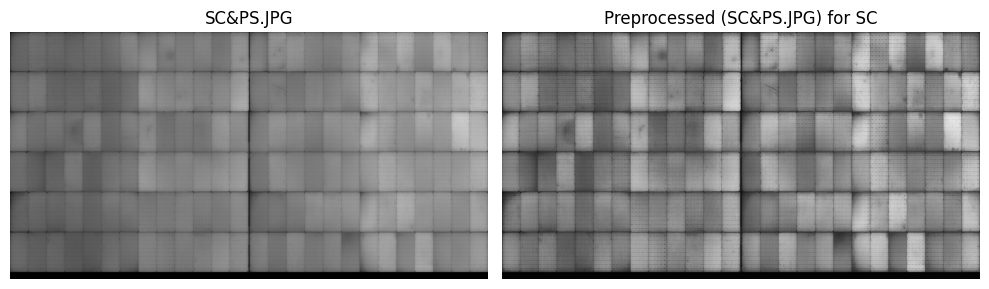

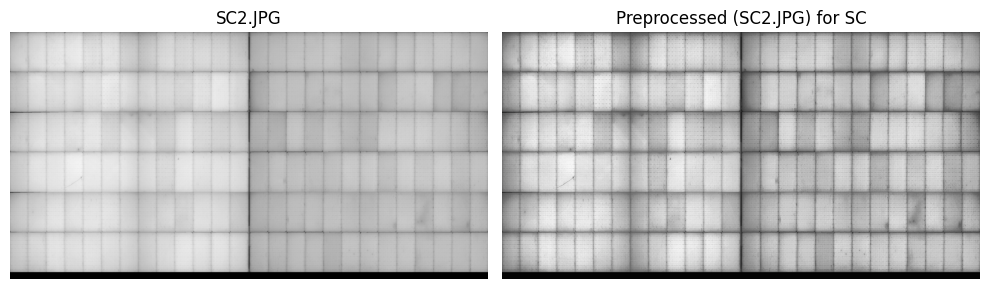

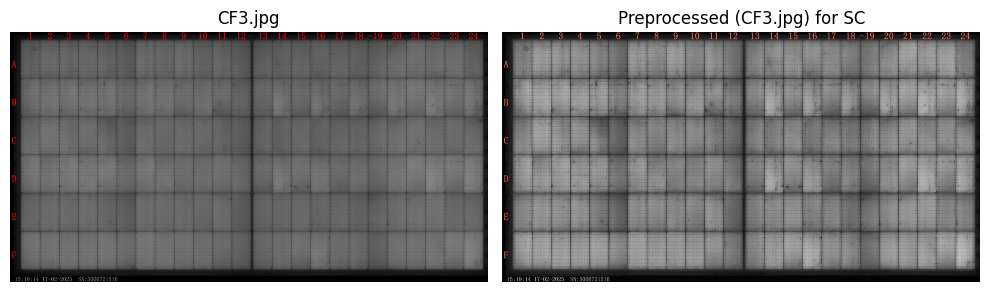

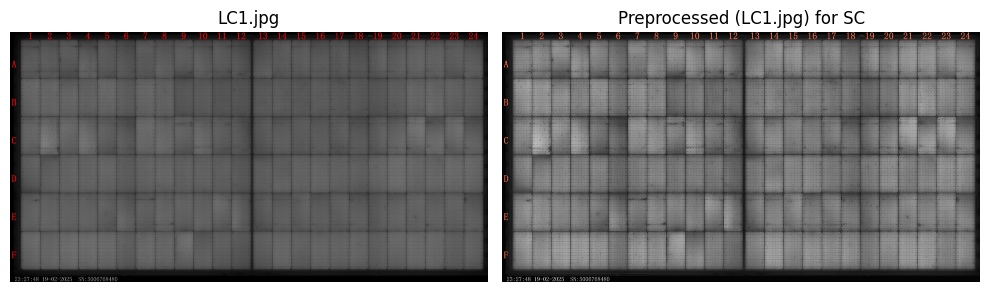

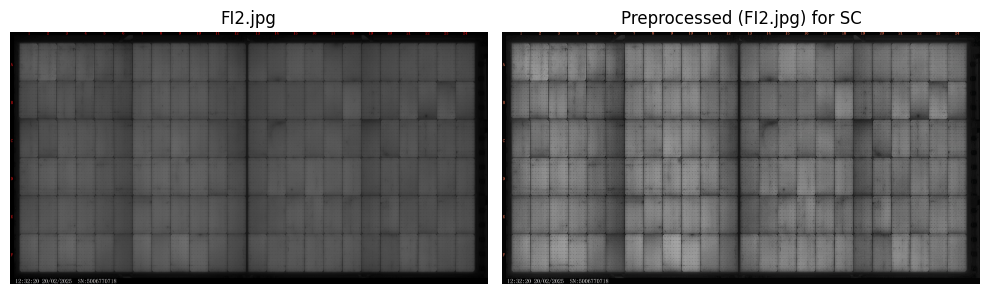

In [ ]:
defect_type = 'SC'
pipeline = defect_pipelines[defect_type]

for path in image_paths[:5]: #check first 5 images
    orig = cv2.imread(path)
    proc = pipeline.run(orig)
    filename = os.path.basename(path)
    visualize(orig, proc,
              title_orig=filename,
              title_proc=f'Preprocessed ({filename}) for {defect_type}')

#### Custom pipeline

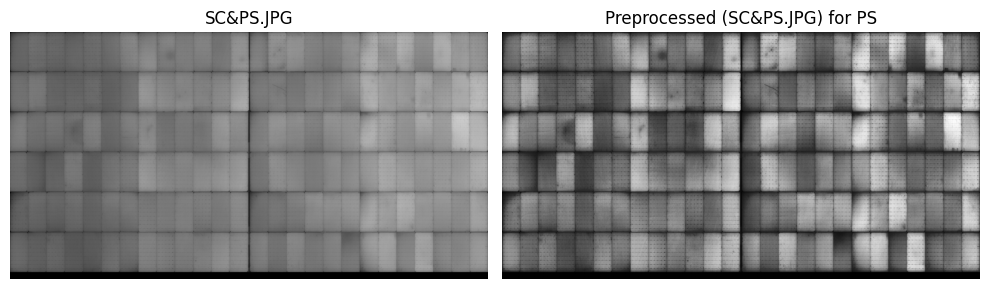

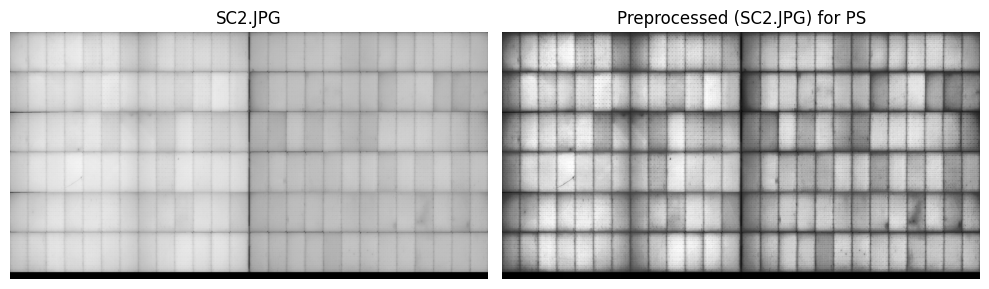

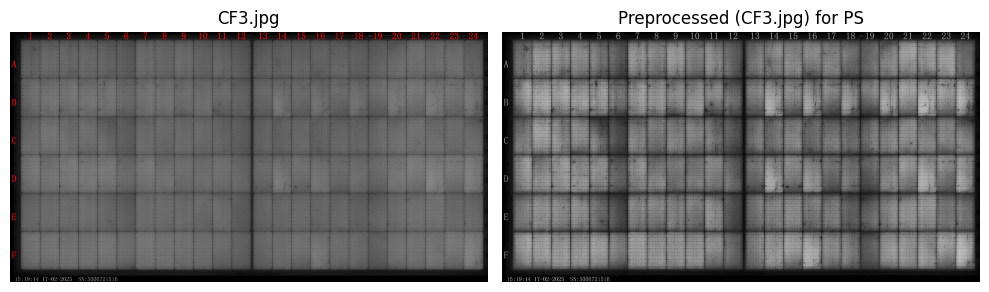

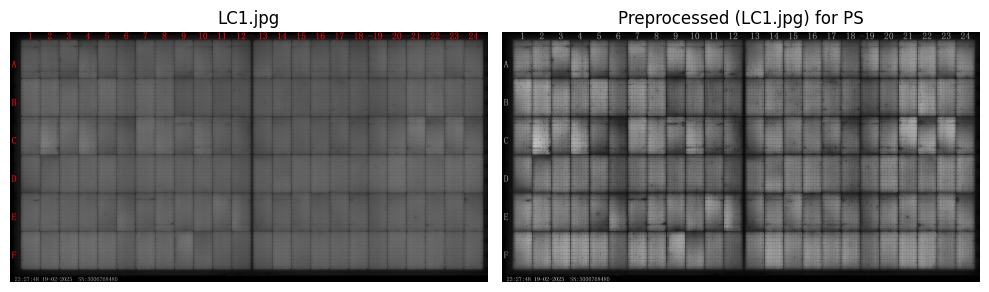

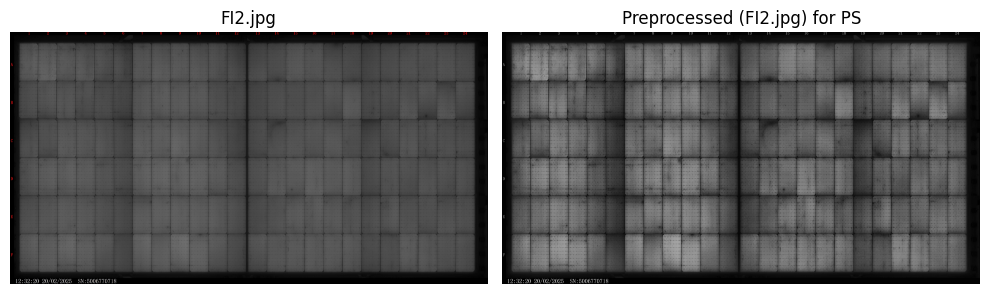

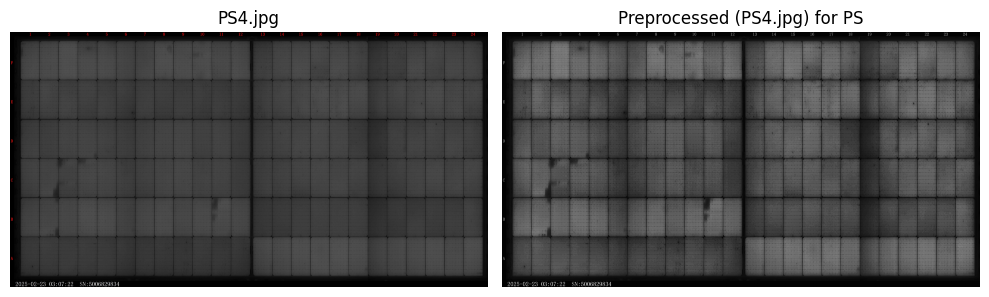

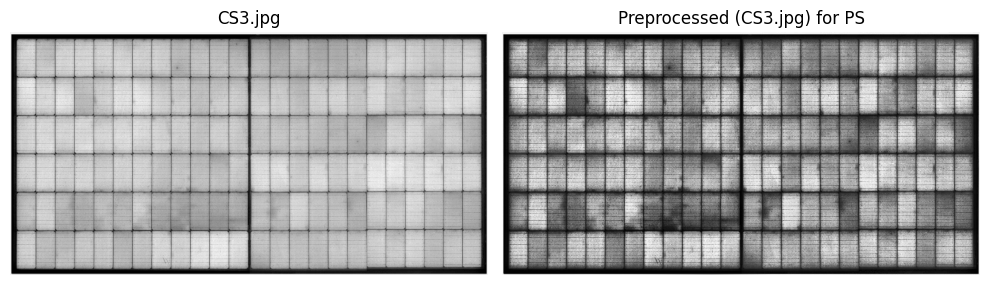

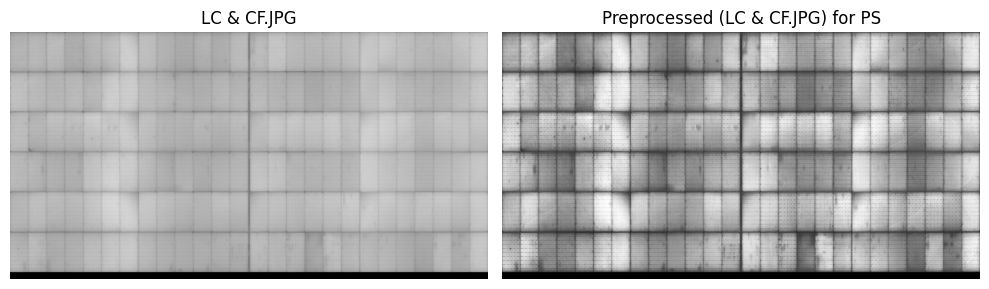

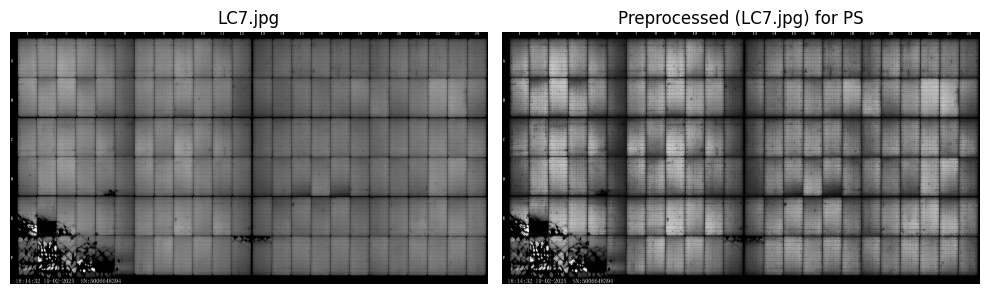

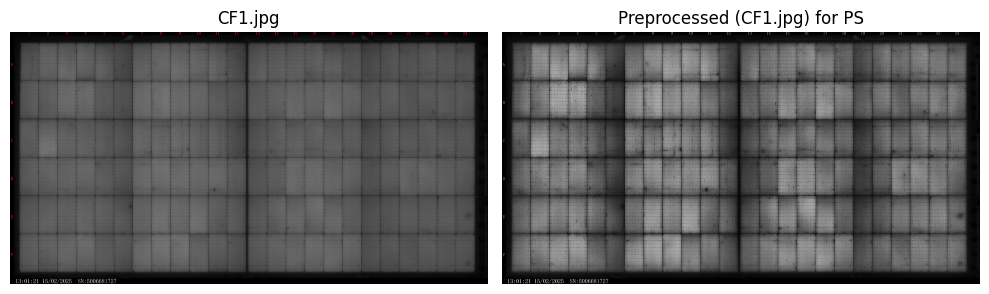

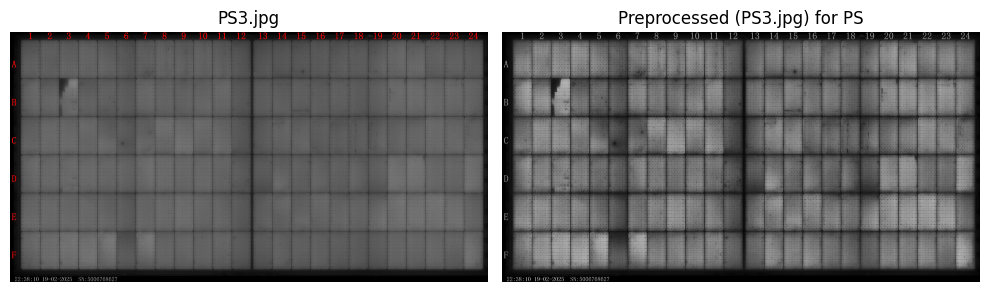

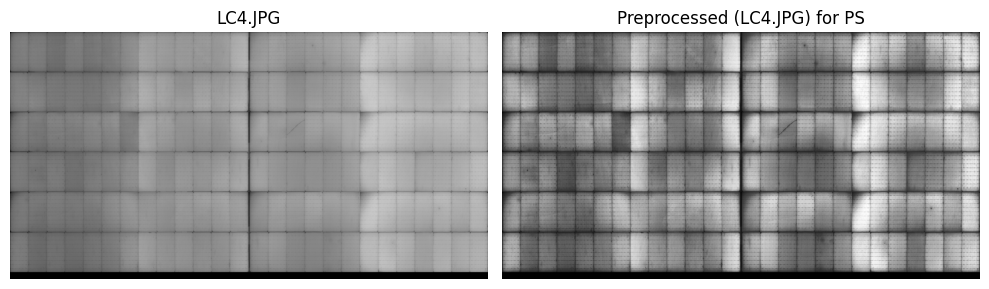

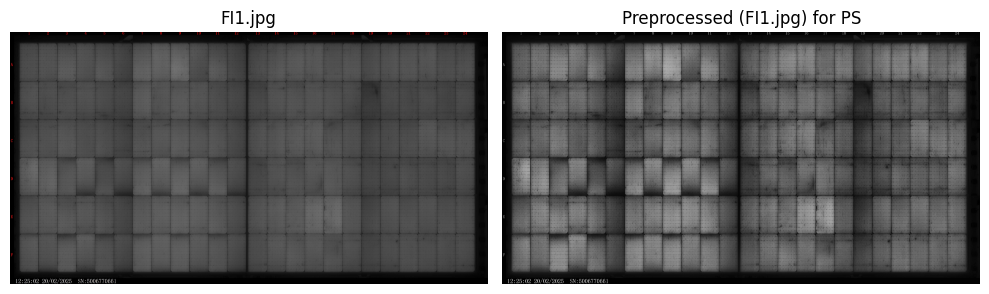

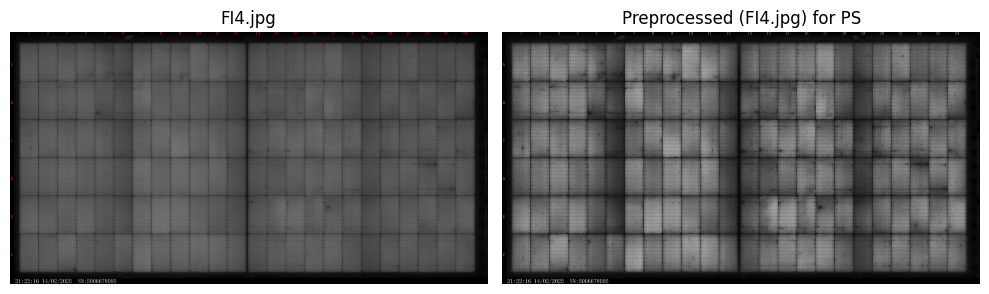

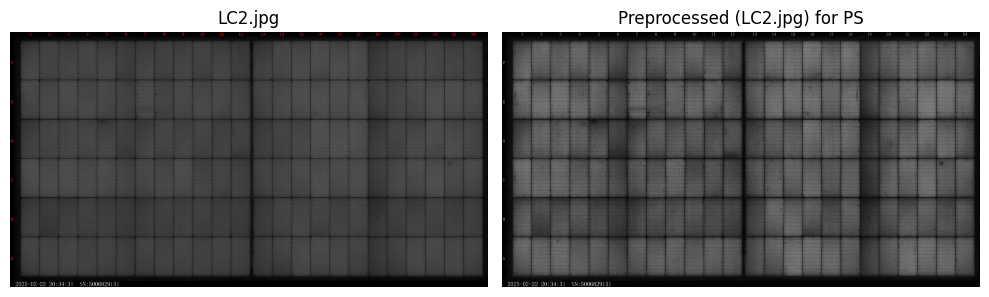

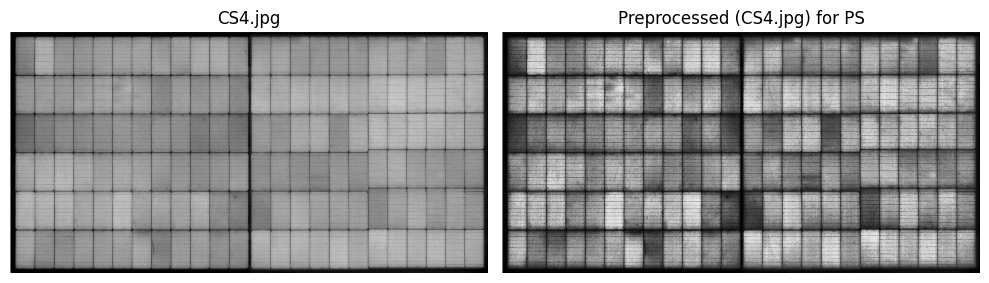

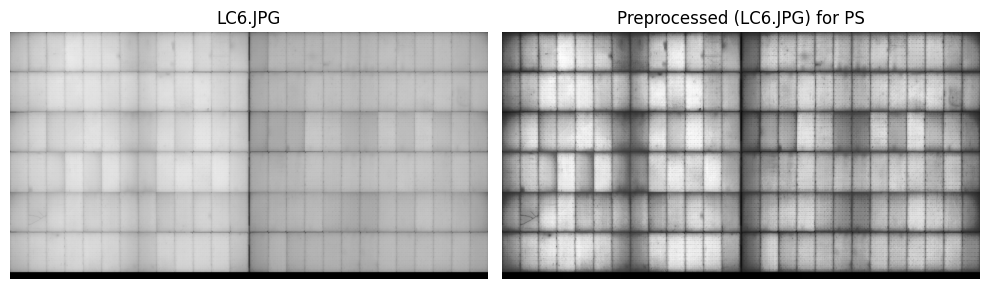

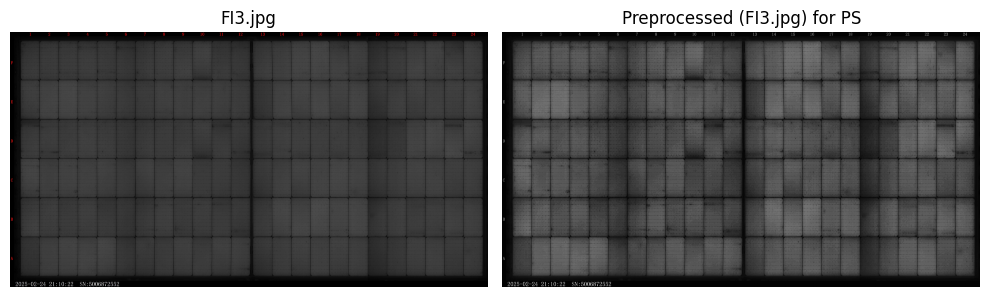

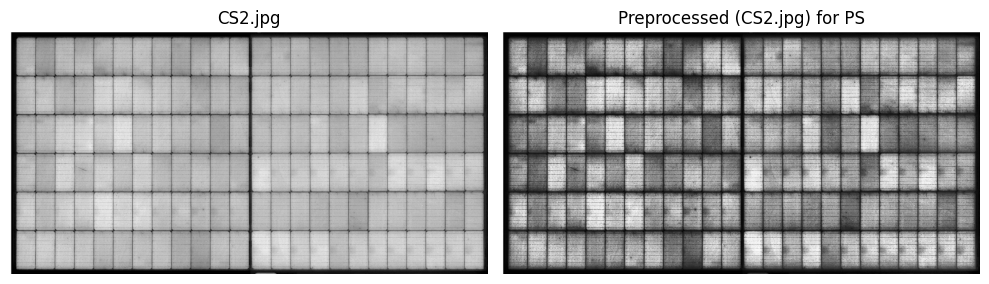

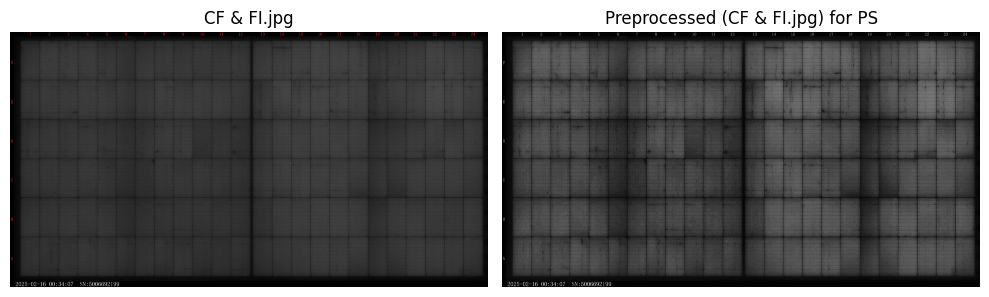

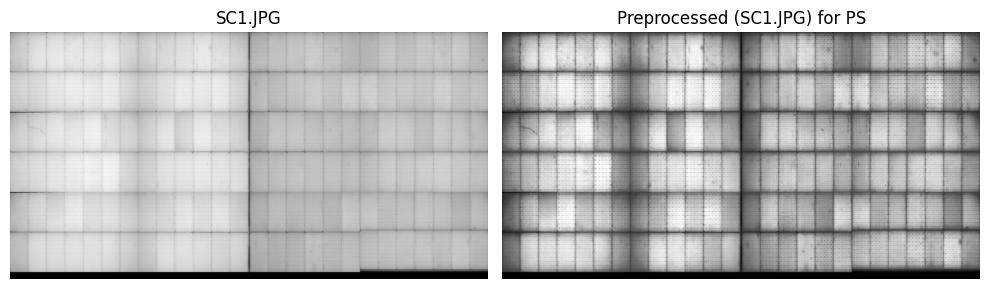

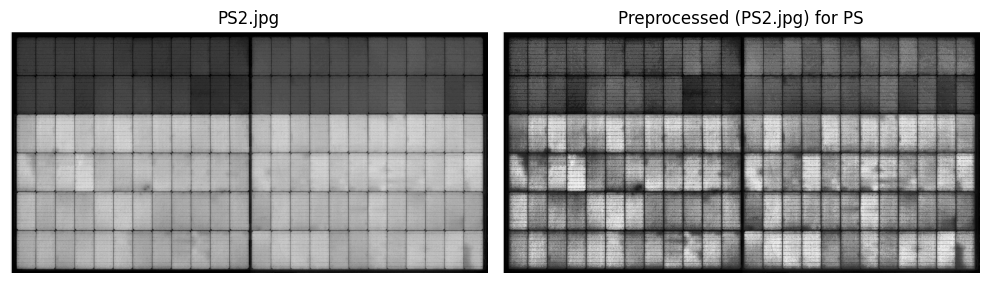

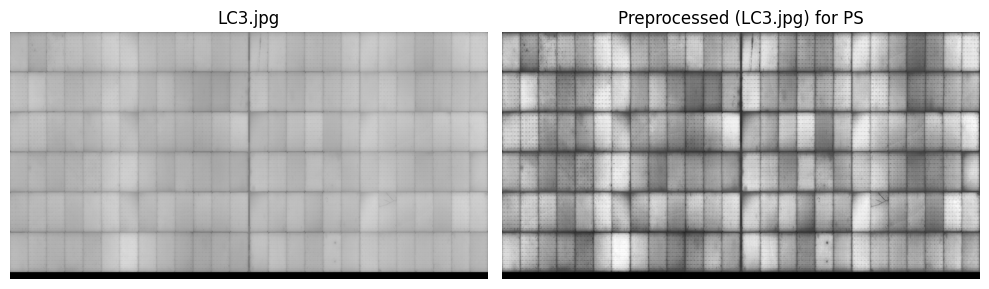

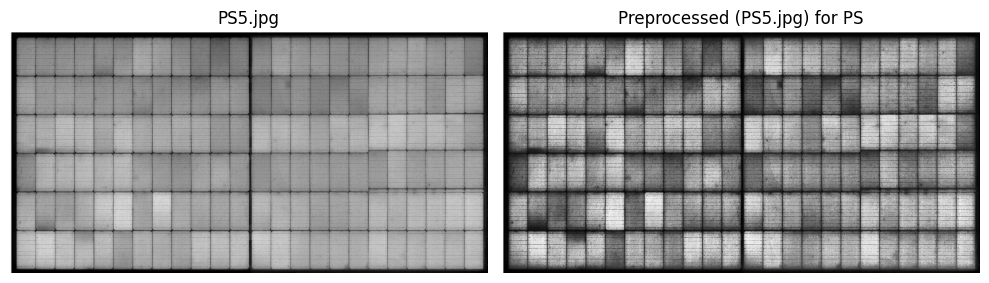

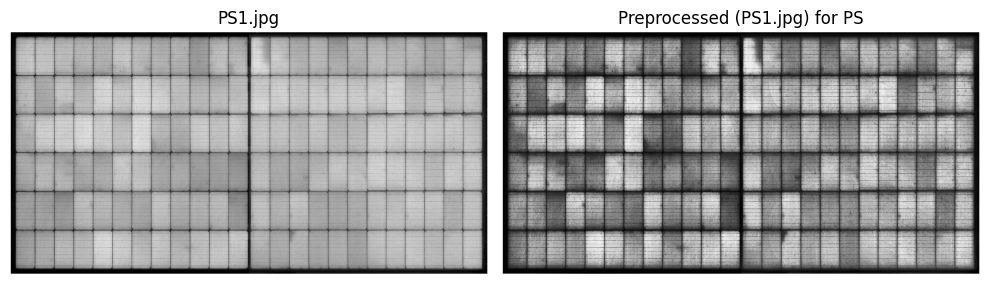

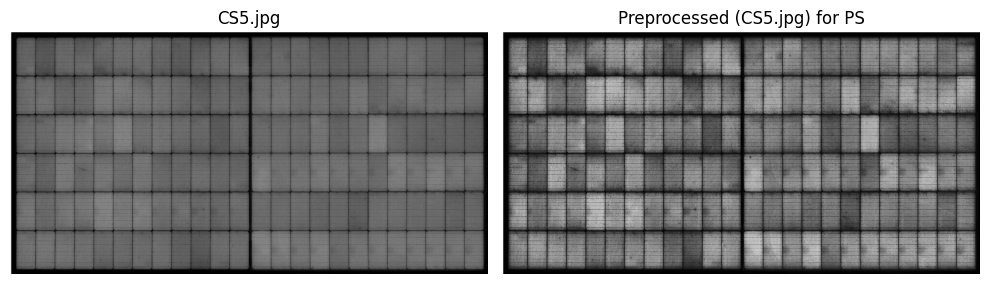

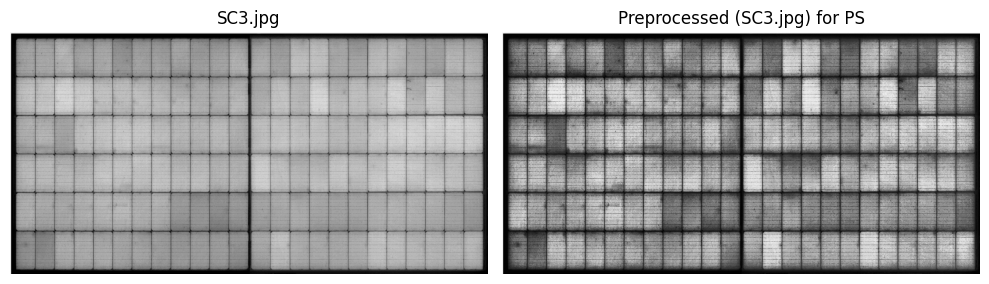

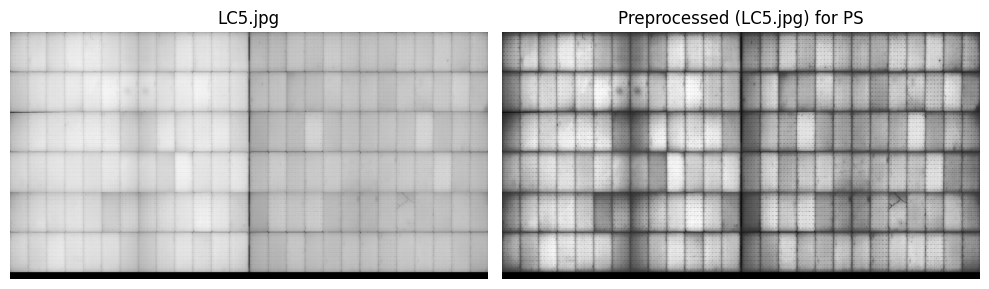

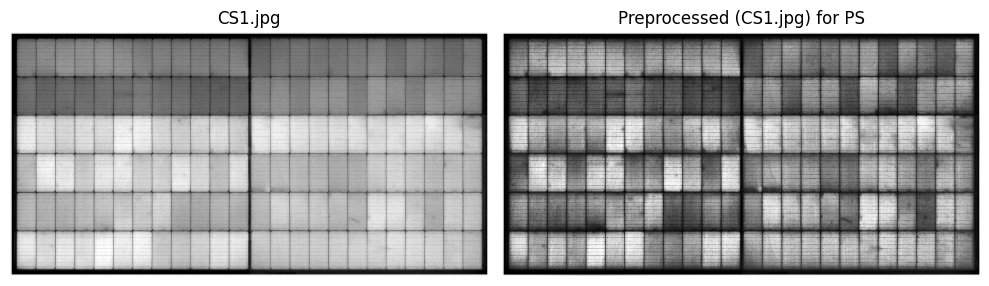

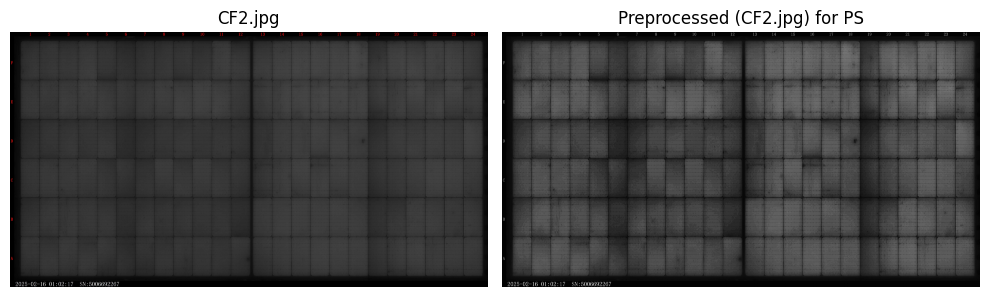

In [ ]:
ps_pipeline = ELPreprocessor() \
    .add(apply_clahe, clip_limit=3.0) \
    .add(gamma_correction, gamma=0.8) \
    .add(lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) \
    # .add(lambda gray: cv2.adaptiveThreshold(
    #         gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #         cv2.THRESH_BINARY,51,5)) \
    # .add(lambda mask: cv2.morphologyEx(
    #         mask, cv2.MORPH_CLOSE,
    #         cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))) \
    # .add(clean_mask, min_area=100, max_area=1500)


for path in image_paths:
    orig = cv2.imread(path)
    proc = ps_pipeline.run(orig)
    filename = os.path.basename(path)
    visualize(orig, proc,
              title_orig=filename,
              title_proc=f'Preprocessed ({filename}) for {defect_type}')
